Deliverables



1. A report (in the form of a presentation, both verbal and through a slides)


2. A github repository containing your jupyter notebook that walks through the pipeline along with the .py files necessary to reproduce your model.



In [24]:
import wrangle
import pandas as pd
import numpy as np
import evaluate
import explore
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, explained_variance_score
from scipy import stats
import split_scale
import feature_selection
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import QuantileTransformer, quantile_transform

In [50]:
#use wrangle.py to import data from mySQL
df =wrangle.get_data_from_sql()

In [51]:
# check DF head
df.head()

,bathrooms,bedrooms,square_feet,fips,lot_size,pool,zip_code,year_built,latitude,longitude,assessed_value,tax_value,transaction_date
0,2.0,3.0,1458.0,6037.0,8284.0,1.0,97318.0,1970.0,34686163.0,-118113100.0,136104.0,2319.90,2017-06-23
1,1.0,2.0,1421.0,6037.0,6707.0,NaN,96018.0,1911.0,33999877.0,-118291863.0,35606.0,543.69,2017-06-30
2,3.0,4.0,2541.0,6059.0,4975.0,NaN,96958.0,2003.0,33694636.0,-117912245.0,880456.0,9819.72,2017-06-01
3,2.0,3.0,1650.0,6037.0,7300.0,NaN,96037.0,1949.0,33985377.0,-118361620.0,614000.0,7673.19,2017-06-01
4,1.0,2.0,693.0,6037.0,2908.0,NaN,96023.0,1921.0,34112946.0,-118208106.0,274237.0,3267.47,2017-06-29


In [52]:
# check DF tail
df.tail()

,bathrooms,bedrooms,square_feet,fips,lot_size,pool,zip_code,year_built,latitude,longitude,assessed_value,tax_value,transaction_date
14985,3.0,5.0,2526.0,6059.0,7800.0,1.0,97018.0,1994.0,33753643.0,-117766503.0,458903.0,5718.72,2017-06-30
14986,3.0,5.0,2735.0,6059.0,7100.0,1.0,97067.0,1963.0,33783173.0,-117817799.0,115387.0,1465.88,2017-06-30
14987,2.0,3.0,1536.0,6037.0,8818.0,1.0,96523.0,1955.0,34058178.0,-117948180.0,297097.0,3519.78,2017-06-30
14988,3.0,5.0,2655.0,6059.0,6000.0,NaN,97065.0,1994.0,33836898.0,-117801369.0,746963.0,8065.50,2017-06-30
14989,3.0,4.0,2305.0,6037.0,5742.0,NaN,96129.0,1949.0,33952368.0,-118441155.0,579047.0,6996.21,2017-06-30


In [53]:
# there are null values in lot_size, pool, zip_code, year_built and tax-value
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14990 entries, 0 to 14989
Data columns (total 13 columns):
bathrooms           14990 non-null float64
bedrooms            14990 non-null float64
square_feet         14990 non-null float64
fips                14990 non-null float64
lot_size            14893 non-null float64
pool                3287 non-null float64
zip_code            14982 non-null float64
year_built          14974 non-null float64
latitude            14990 non-null float64
longitude           14990 non-null float64
assessed_value      14990 non-null float64
tax_value           14989 non-null float64
transaction_date    14990 non-null object
dtypes: float64(12), object(1)
memory usage: 1.5+ MB


In [54]:
#wrangle data to remove NANs
df = wrangle.wrangle_zillow()

In [55]:
#create a new column tax-rate
df['tax_rate'] = df.tax_value/df.assessed_value

In [56]:
df.head(2)

,bathrooms,bedrooms,square_feet,fips,lot_size,pool,zip_code,year_built,latitude,longitude,assessed_value,tax_value,transaction_date,tax_rate
0,2.0,3.0,1458.0,6037,8284,1,97318,1970,34686163.0,-118113100.0,136104.0,2319.90,2017-06-23,0.017045
1,1.0,2.0,1421.0,6037,6707,0,96018,1911,33999877.0,-118291863.0,35606.0,543.69,2017-06-30,0.015270


In [57]:
#https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_013697
#source for county fips code. Read codes in a data DataFrame named fips_codes
#fips_codes = pd.read_clipboard()

In [58]:
fips_code = pd.DataFrame({
    'fips': [6037, 6059, 6111],
    'County':['Los Angles', 'Orange', 'Ventura']
})
fips_code.head()

,fips,County
0,6037,Los Angles
1,6059,Orange
2,6111,Ventura


In [59]:
#merge df and fips_codes 
df = pd.merge(df, fips_code, left_on='fips', right_on='fips', how='left')

In [60]:
df.head(2)

,bathrooms,bedrooms,square_feet,fips,lot_size,pool,zip_code,year_built,latitude,longitude,assessed_value,tax_value,transaction_date,tax_rate,County
0,2.0,3.0,1458.0,6037,8284,1,97318,1970,34686163.0,-118113100.0,136104.0,2319.90,2017-06-23,0.017045,Los Angles
1,1.0,2.0,1421.0,6037,6707,0,96018,1911,33999877.0,-118291863.0,35606.0,543.69,2017-06-30,0.015270,Los Angles


In [61]:
#split the data into train and test
train, test = train_test_split(df, train_size = .70, random_state = 100)

# Data Exploration (Using train data only)

In [188]:
#create a subset of df with continuous variables to create pairplot
train_plot = df[['bathrooms', 'bedrooms', 'square_feet', 'lot_size', 'assessed_value']]

In [189]:
train_plot.head(2)

,bathrooms,bedrooms,square_feet,lot_size,assessed_value
0,2.0,3.0,1458.0,8284,136104.0
1,1.0,2.0,1421.0,6707,35606.0


In [200]:
df[df.assessed_value<1000000].count()[1]/df.shape[0]

0.8911450279029113

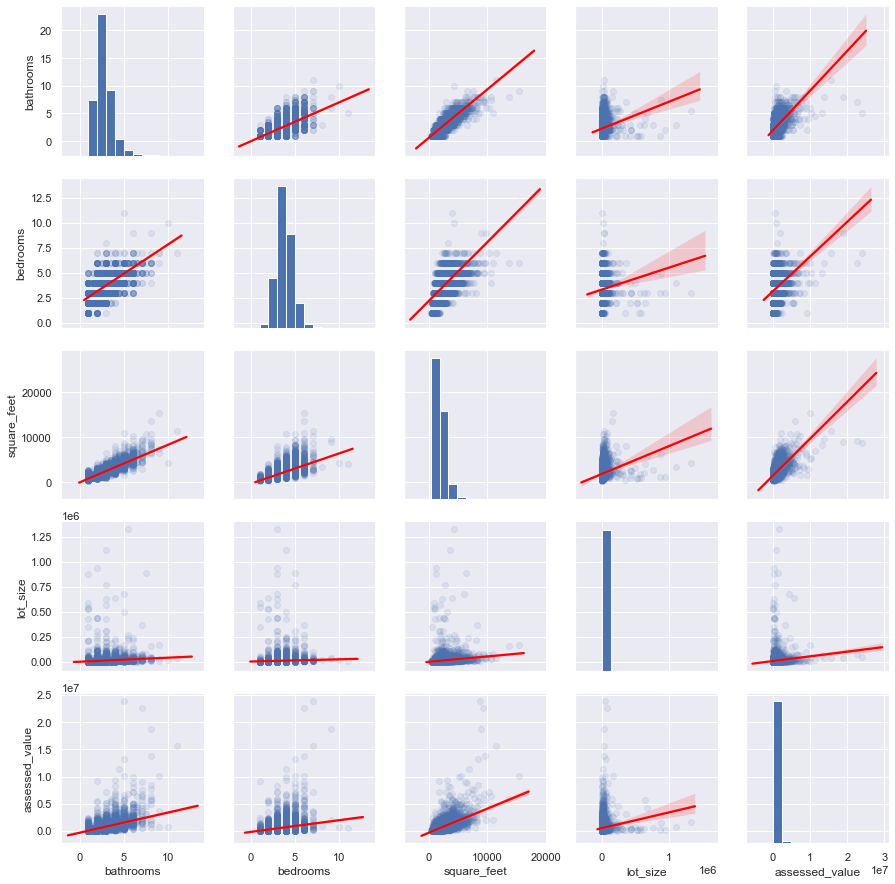

In [190]:
explore.plot_variable_pairs(train_plot)

# Home value seems to be correlated to number of bathrooms, bedrooms, square_feet and lot size

In [ ]:
# Lets look at box plot of home values in each county. For better visualization, homes above 1 million are not plotted
plt.figure(figsize=(12,6))
sns.boxplot(x= train[train.assessed_value<100000].County, y= train[train.assessed_value<100000].assessed_value, data=train[train.assessed_value<100000])

In [ ]:
train.head()

In [ ]:
# median value of homes is a better measure of central tendency for home values due to outliers.
train[train.assessed_value <1000000].assessed_value.median()

In [ ]:
# plot showing distribution of home values. This looks like right skewed distribution
sns.distplot(train.assessed_value)

In [ ]:
cm = train_plot.corr()
cm

In [ ]:
# lets look at heatmap and corresponding correlation values 
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, cmap='viridis')

# $H_0$: there is no relationship between home values and number of bedrooms, bathrooms and square_feet
# $H_a$: There is a relationship between home values and number of bedrooms, bathrooms and square_feet

In [ ]:
#Lets take a look at simple model based on bathoom, bedroom and squarefeet and compare if against the baseline(median home value)
X_train = train[['bedrooms', 'bathrooms', 'square_feet']]
y_train = train[['assessed_value']]
y_train['y_baseline'] = train['assessed_value'].median()

In [ ]:
y_train.head()

In [ ]:
# Calculating the baseline (based on median) RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse_bl = sqrt(mean_squared_error(y_train.assessed_value, y_train.y_baseline))

rmse_bl

In [ ]:
#We now create a OLS model based on bedrooms, bathrooms and square_feet
from statsmodels.formula.api import ols

# generate parameters, i.e. create model
ols_model = ols('assessed_value ~ bedrooms + bathrooms + square_feet', data = train).fit()

# compute predictions and add to original dataframe
y_train['yhat'] = ols_model.predict(X_train)

In [ ]:
y_train.head()

In [ ]:
ols_model.summary()

# Since my p-value is <0.05, I can reject my null hypothesis.
# This means that there is statistically significant relationship between home prices and  independent variables used above.

In [ ]:

rmse = sqrt(mean_squared_error(y_train.assessed_value, y_train.yhat))
rmse

#  RMSE for OLS model with bedrooom, bathroom and square feet (578329) is lower than the baseline (based on median)748179.  R2 is 0.37 and p-value is 0.

# I am next going to build a simple linear regression model based on bathrooms, bedrooms and square feet

In [ ]:
# make a dataframe 'predictions' with actual home values
predictions = pd.DataFrame({
    'actual': y_train.assessed_value
})
predictions.head()

In [ ]:
X_train1 = X_train[['bedrooms', 'bathrooms', 'square_feet']]
y_train1 = y_train[['assessed_value']]

In [ ]:
#linear regression model
lm = LinearRegression()

In [ ]:
# fit our train data on the model
lm.fit(X_train1, y_train1)

In [ ]:
print("Linear Model:", lm)

print("intercept: ", lm.intercept_)

print("coefficients: ", lm.coef_)

In [ ]:
#predictions from linear regresssion model based on X_train independent variable values
predictions['yhat_lm'] = lm.predict(X_train1)

In [ ]:
#Baseline predicted home value (median home price)
predictions['baseline'] = y_train.assessed_value.median()

In [ ]:
predictions.head(2)

In [ ]:
# Use lamda and calculate RMSE for each columns in prediction dataframe
pd.options.display.float_format = '{:.3f}'.format
predictions.apply(lambda col: sqrt(mean_squared_error(predictions.actual, col)))

# The RMSE above for the linear model is better than baseline

# Lets use this model on test data and see how well it does there

In [ ]:
#using test data and predicting home values based on linear model above
X_test = test[['bedrooms', 'bathrooms', 'square_feet']]
y_test = test[['assessed_value']]
y_test['test_prediction'] = lm.predict(X_test)

In [ ]:
y_test.rename(columns = {'assessed_value': 'actual'}, inplace = True)

In [ ]:
y_test.head(2)

In [ ]:
#Calculating RMSE for test predictions
y_test.apply(lambda col: sqrt(mean_squared_error(y_test.actual, col)))

# The RMSE for test data is lower than the train data!! This linear means model is working well (atleast better than baseline)

# We will know try to explore this data more and do feature engineering to see if we can do better than the model above

Seems like most of the data is from LA county followed by Orange and then Ventura county

Text(0.5, 0, 'County')

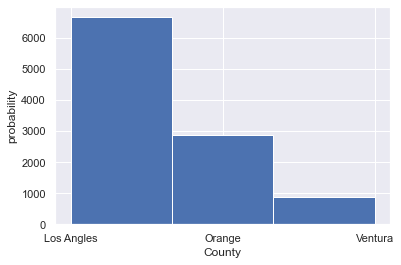

In [62]:
plt.hist(train.County, density=False, bins=3)
plt.ylabel('probability')
plt.xlabel('County')

Text(0.5, 0, 'Number of bathrooms')

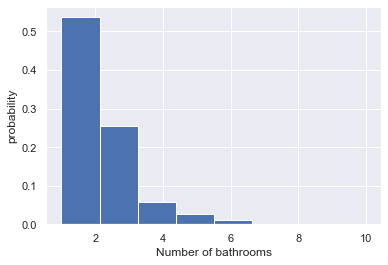

In [63]:
plt.hist(train.bathrooms, density=True, bins=8)  # `density=False` would make counts
plt.ylabel('probability')
plt.xlabel('Number of bathrooms')


Text(0.5, 0, 'Number of bedrooms')

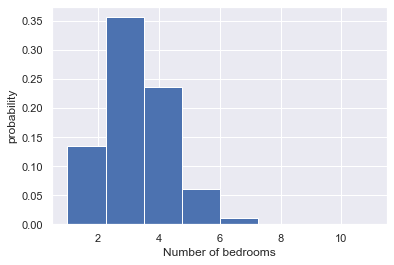

In [64]:
plt.hist(train.bedrooms, density=True, bins=8)  # `density=False` would make counts
plt.ylabel('probability')
plt.xlabel('Number of bedrooms')



Text(0.5, 0, 'Year built')

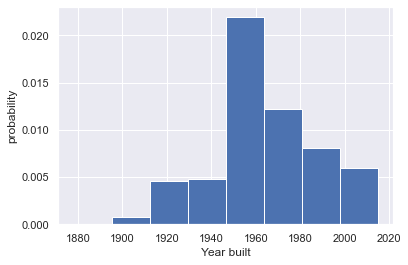

In [65]:
plt.hist(train.year_built, density=True, bins=8)  # `density=False` would make counts
plt.ylabel('probability')
plt.xlabel('Year built')

Text(0.5, 0, 'Square Feet')

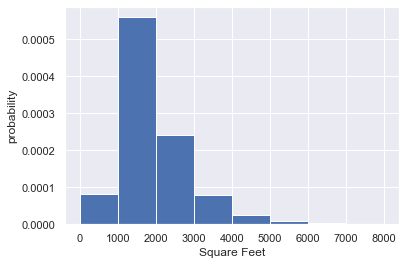

In [66]:
plt.hist(train.square_feet, density=True, bins=[0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000])  # `density=False` would make counts
plt.ylabel('probability')
plt.xlabel('Square Feet')

Text(0.5, 0, 'tax_rate')

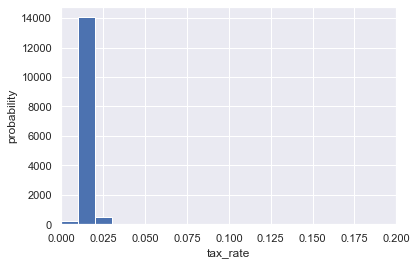

In [67]:
plt.hist(df.tax_rate, density=False, bins=[0, 0.01, 0.02, 0.03, 0.04, 0.05])  # `density=False` would make counts
plt.ylabel('probability')
plt.xlim(0,0.2)
plt.xlabel('tax_rate')

Text(0.5, 0, 'assessed_value')

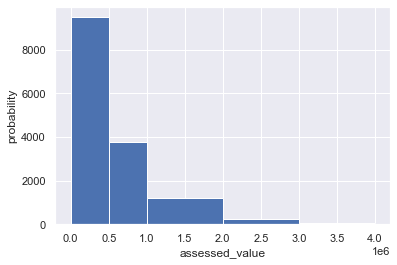

In [68]:
plt.hist(df.assessed_value, density=False, bins =[0, 500000, 1000000, 2000000, 3000000, 4000000])  # `density=False` would make counts
plt.ylabel('probability')
#plt.xlim(0,0.2)
plt.xlabel('assessed_value')

(0.0, 0.04)

<Figure size 864x432 with 0 Axes>

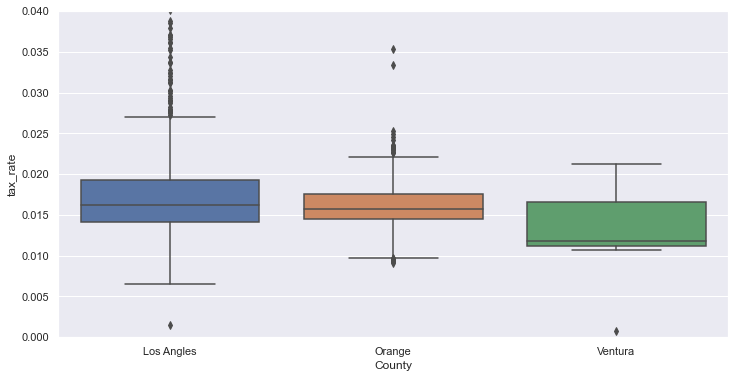

In [69]:
plt.figure(figsize=(12,6))
plt.figure(figsize=(12,6))
sns.boxplot(x= train[train.assessed_value<100000].County, y= train[train.assessed_value<100000].tax_rate, data=train[train.assessed_value<100000])
plt.ylim(0,0.04)

# It seems like tax rate (average) is higher compared to Orange and Ventura counties

In [ ]:
plt.figure(figsize=(12,4))
# below are plots for tax_rate distributions in three counties
sns.distplot(df[df.County == 'Los Angles'].tax_rate, rug=True)
plt.show()
plt.figure(figsize=(12,4))
sns.distplot(df[df.County == 'Orange'].tax_rate, rug=True)
plt.show()
plt.figure(figsize=(12,4))
sns.distplot(df[df.County == 'Ventura'].tax_rate, rug=True)

# Lets see if we can add new features to our model. We start by exploring other variables and their correlation with home values. We will use train data for this exploration

In [70]:
train_plot2 = train[['assessed_value','bedrooms', 'bathrooms', 'square_feet', 'lot_size', 'year_built']]
X_train2 = train[['bedrooms', 'bathrooms', 'square_feet', 'lot_size', 'year_built']]
X_test2 = test[['bedrooms', 'bathrooms', 'square_feet', 'lot_size', 'year_built']]

In [71]:
cm = train_plot2.corr()
cm

,assessed_value,bedrooms,bathrooms,square_feet,lot_size,year_built
assessed_value,1.000000,0.263875,0.505229,0.588502,0.131576,0.170843
bedrooms,0.263875,1.000000,0.641827,0.628387,0.087423,0.391171
bathrooms,0.505229,0.641827,1.000000,0.854944,0.159933,0.523995
square_feet,0.588502,0.628387,0.854944,1.000000,0.206333,0.464001
lot_size,0.131576,0.087423,0.159933,0.206333,1.000000,0.084064
year_built,0.170843,0.391171,0.523995,0.464001,0.084064,1.000000


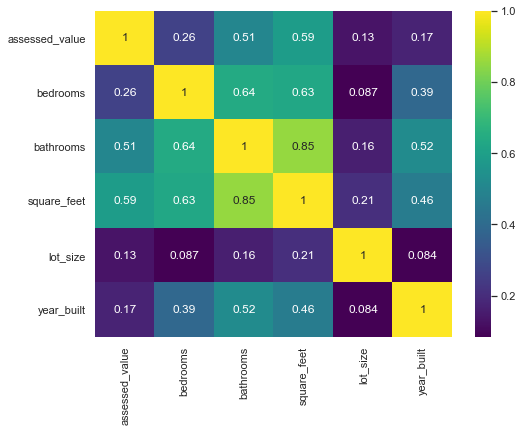

In [72]:
# lets look at heatmap and corresponding correlation values 
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, cmap='viridis')

The heatmap suggests some correlation between lot_size,year_built and home value too.

The histograms above for bedroom, bathroom and square_feet are right skewed. We can possibly tranform the data using log scale to make them more 'normal'

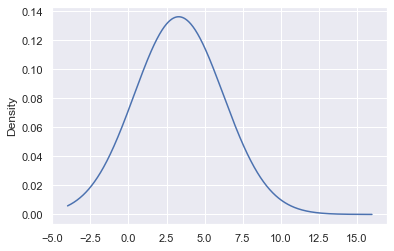

In [73]:
df.bedrooms.plot.kde(bw_method=3)


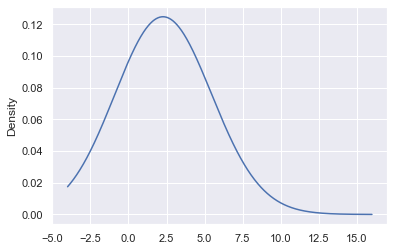

In [74]:
df.bathrooms.plot.kde(bw_method=3)

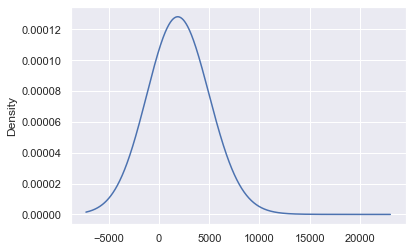

In [75]:
df.square_feet.plot.kde(bw_method=3)

lets use standard scaler and scale all independent variables

In [76]:
#scaler, X_train_scaled,  X_test_scaled= split_scale.robust_scalar_scaler(X_train2, X_test2)
scaler, X_train_scaled, X_test_scaled = split_scale.iqr_robust_scaler(X_train2, X_test2)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12a435990>,
      dtype=object)

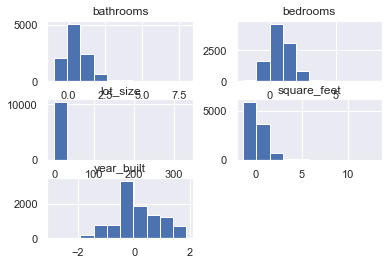

In [77]:
X_train_scaled.hist()

In [83]:
y_train = train[['assessed_value']]

In [84]:
lm = LinearRegression()

In [85]:
rfe = RFE(lm, 4)

In [86]:
X_rfe = rfe.fit_transform(X_train_scaled,y_train)

In [87]:
mask = rfe.support_

# select the column names of the features that were selected and convert them to a list for future use. 
rfe_features = X_train_scaled.columns[mask]

# print them out here for our reference
print(f'selected {len(rfe_features)} features:', ', '.join(rfe_features))

selected 4 features: bedrooms, bathrooms, square_feet, year_built


In [88]:
lm = LinearRegression()

In [89]:
lm.fit(X_rfe, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [90]:
print("Linear Model:", lm)

print("intercept: ", lm.intercept_)

print("features: ", rfe_features)
print("coefficients: ", lm.coef_)

Linear Model: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
intercept:  [443159.20546056]
features:  Index(['bedrooms', 'bathrooms', 'square_feet', 'year_built'], dtype='object')
coefficients:  [[-137557.52383447   97862.94724899  499392.7646885  -116826.56048029]]


In [91]:
X_rfe

array([[ 0.        ,  1.        ,  0.4249531 ,  0.93103448],
       [ 1.        ,  0.        ,  0.02626642, -0.03448276],
       [ 0.        ,  0.        ,  0.31613508, -0.86206897],
       ...,
       [ 0.        ,  0.        , -0.21013133, -0.31034483],
       [ 1.        ,  0.5       ,  0.82363977,  1.4137931 ],
       [ 1.        ,  0.        , -0.19418386,  0.06896552]])

In [92]:
predictions['yhat_lm_rfe'] = lm.predict(X_rfe)

NameError: name 'predictions' is not defined

In [93]:
predictions.apply(lambda col: sqrt(mean_squared_error(predictions.actual, col)))

NameError: name 'predictions' is not defined

In [ ]:
predictions.head()

In [ ]:
evaluate.plot_residuals(predictions.actual, predictions.yhat_lm_rfe, predictions)
evaluate.plot_residuals(predictions.actual, predictions.yhat_lm, predictions)

# Lets apply Linear Regression model using the selected features above to the test dataset

In [94]:
X_test_scaled.head()

,bedrooms,bathrooms,square_feet,lot_size,year_built
9116,0.0,1.0,1.081614,-0.824674,0.620690
2397,0.0,0.5,1.015009,-0.425513,1.379310
2849,0.0,0.0,-0.479362,0.059889,-0.310345
14308,2.0,1.0,1.332083,0.663273,1.793103
9780,0.0,0.0,0.304878,0.190448,0.000000


In [95]:
X_test_rfe = rfe.transform(X_test_scaled)

In [96]:
len(X_test_rfe)

4462

In [97]:
y_test1 = test[['assessed_value']]
y_test1['test_prediction'] = lm.predict(X_test_rfe)

In [98]:
print("Linear Model:", lm)

print("intercept: ", lm.intercept_)

print("coefficients: ", lm.coef_)

Linear Model: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
intercept:  [443159.20546056]
coefficients:  [[-137557.52383447   97862.94724899  499392.7646885  -116826.56048029]]


In [99]:
y_test1.head()

,assessed_value,test_prediction
9116,1352462.0,1.008659e+06
2397,797339.0,8.378389e+05
2849,63577.0,2.400258e+05
14308,621836.0,7.216574e+05
9780,362761.0,5.954131e+05


In [100]:
y_test1.apply(lambda col: sqrt(mean_squared_error(y_test1.assessed_value, col)))

NameError: ("name 'sqrt' is not defined", 'occurred at index assessed_value')

The test data has similar RMSE as train data. This means our model is not overfitted

Lets try this model on test data 

In [101]:
y_test1['test_prediction'] = lm.predict(X_test_scaled_rfe)

NameError: name 'X_test_scaled_rfe' is not defined

In [102]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_rfe)

poly.get_feature_names()

['1',
 'x0',
 'x1',
 'x2',
 'x3',
 'x0^2',
 'x0 x1',
 'x0 x2',
 'x0 x3',
 'x1^2',
 'x1 x2',
 'x1 x3',
 'x2^2',
 'x2 x3',
 'x3^2']

In [103]:
lm_poly = LinearRegression()
lm_poly.fit(X_poly, y_train.assessed_value)
y_train['yhat_poly'] = lm_poly.predict(X_poly)

In [104]:
y_train

,assessed_value,yhat_poly
11938,268557.0,665397.268029
790,95849.0,304012.126317
3846,324613.0,588795.710062
14846,499860.0,715074.443137
1469,517777.0,320495.661680
...,...,...
12119,1321024.0,852420.071853
8039,447349.0,321359.366871
14147,665588.0,351919.440391
6936,518732.0,534956.046334


In [105]:
y_train.apply(lambda col: sqrt(mean_squared_error(y_train.assessed_value, col)))

NameError: ("name 'sqrt' is not defined", 'occurred at index assessed_value')

# polynomial model is only marginally better

# Lets try to create new feature with Log scale (I am using Log with base 2). Square feet and lot size are good candidates for log scale

In [106]:
df['log2sf'] = np.log2(df['square_feet'])
df['log2lot_size'] = np.log2(df['lot_size'])
df['log2value'] = np.log2(df['assessed_value'])
df['age'] = 2000-df.year_built

In [107]:
df.head(2)

,bathrooms,bedrooms,square_feet,fips,lot_size,pool,zip_code,year_built,latitude,longitude,assessed_value,tax_value,transaction_date,tax_rate,County,log2sf,log2lot_size,log2value,age
0,2.0,3.0,1458.0,6037,8284,1,97318,1970,34686163.0,-118113100.0,136104.0,2319.90,2017-06-23,0.017045,Los Angles,10.509775,13.016112,17.054350,30
1,1.0,2.0,1421.0,6037,6707,0,96018,1911,33999877.0,-118291863.0,35606.0,543.69,2017-06-30,0.015270,Los Angles,10.472691,12.711452,15.119833,89


In [108]:
train_plot = df[['bathrooms', 'bedrooms', 'log2sf', 'log2lot_size', 'log2value', 'age']]

In [109]:
train_plot.head()

,bathrooms,bedrooms,log2sf,log2lot_size,log2value,age
0,2.0,3.0,10.509775,13.016112,17.054350,30
1,1.0,2.0,10.472691,12.711452,15.119833,89
2,3.0,4.0,11.311181,12.280481,19.747891,-3
3,2.0,3.0,10.688250,12.833681,19.227879,51
4,1.0,2.0,9.436712,11.505812,18.065064,79


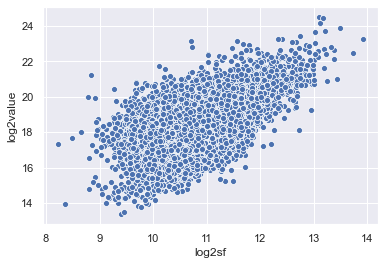

In [110]:
sns.scatterplot(x='log2sf', y = 'log2value', data=train_plot)

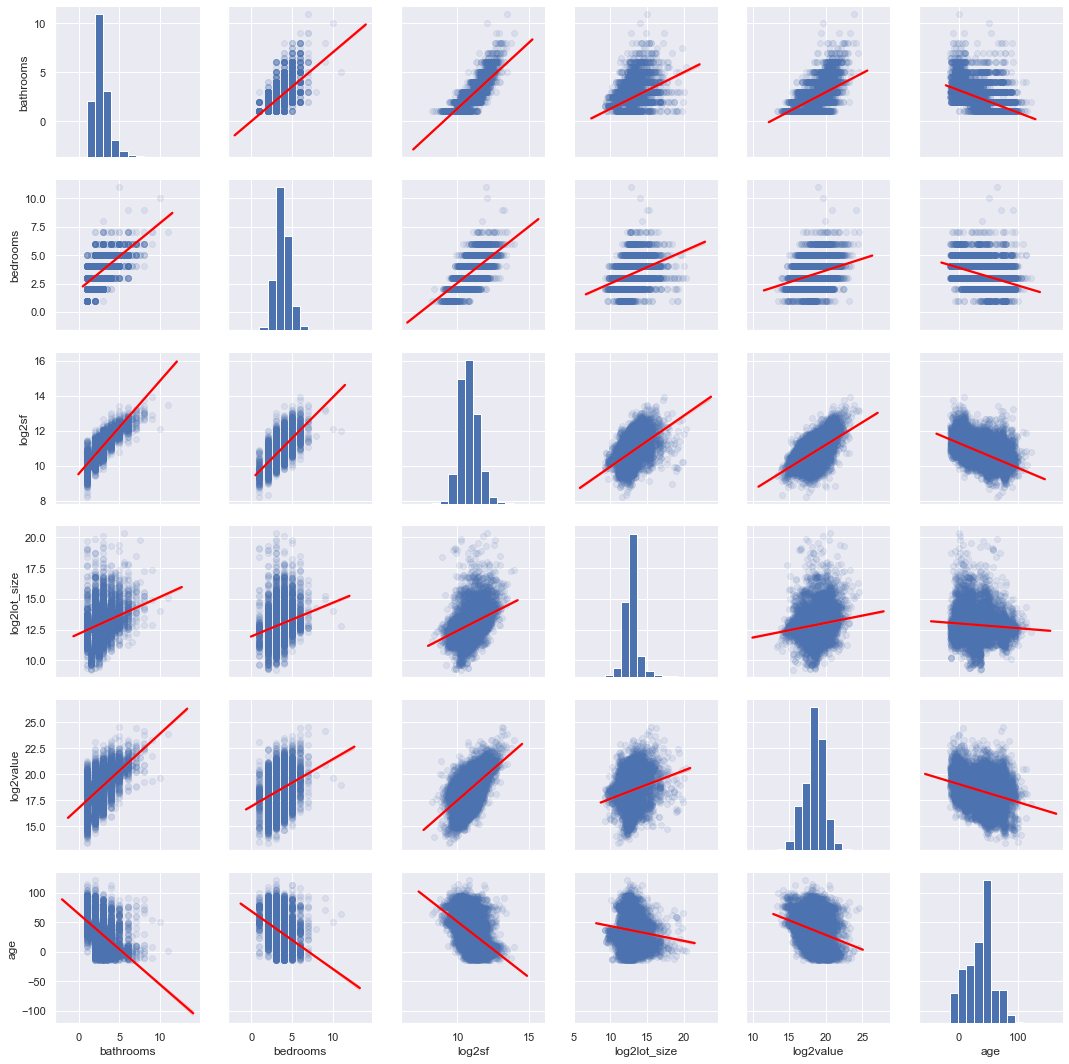

In [111]:
explore.plot_variable_pairs(train_plot)

In [112]:
train, test = train_test_split(df, train_size = .70, random_state = 100)

In [202]:
X_train3 = train[['bedrooms', 'bathrooms', 'log2sf', 'log2lot_size', 'age']]
X_test3 = test[['bedrooms', 'bathrooms', 'log2sf' , 'log2lot_size', 'age']]

In [203]:
y_train3 = train[['log2value',]]
y_test3 = test[['log2value']]

In [204]:
y_train3.head(2)

,log2value
11938,18.034869
790,16.548476


In [205]:
lm = LinearRegression()

In [206]:
rfe = RFE(lm, 2)

In [207]:
X_rfe = rfe.fit_transform(X_train3,y_train3)

In [208]:
X_rfe

array([[ 3.        , 11.05663772],
       [ 2.        , 10.73555602],
       [ 2.        , 10.97584797],
       ...,
       [ 2.        , 10.50481899],
       [ 2.5       , 11.31910758],
       [ 2.        , 10.52160044]])

In [209]:
mask = rfe.support_

# select the column names of the features that were selected and convert them to a list for future use. 
rfe_features = X_train3.columns[mask]

# print them out here for our reference
print(f'selected {len(rfe_features)} features:', ', '.join(rfe_features))

selected 2 features: bathrooms, log2sf


In [210]:
lm = LinearRegression()

In [211]:
lm.fit(X_rfe, y_train3)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [212]:
predictions1 = y_train3.copy()

In [213]:
predictions1['y_log_lm'] = lm.predict(X_rfe)

In [214]:
predictions1['median_bl'] = y_train3.log2value.median()

In [215]:
predictions1.head()

,log2value,y_log_lm,median_bl
11938,18.034869,18.831991,18.571671
790,16.548476,18.302960,18.571671
3846,18.308361,18.503971,18.571671
14846,18.931165,18.963896,18.571671
1469,18.981971,18.030114,18.571671


In [216]:
predictions1['actual'] = train['assessed_value']

In [217]:
predictions1['calculated'] = 2**predictions1.y_log_lm

In [218]:
predictions1

,log2value,y_log_lm,median_bl,actual,calculated
11938,18.034869,18.831991,18.571671,268557.0,466653.160500
790,16.548476,18.302960,18.571671,95849.0,323400.003135
3846,18.308361,18.503971,18.571671,324613.0,371749.488103
14846,18.931165,18.963896,18.571671,499860.0,511330.349588
1469,18.981971,18.030114,18.571671,517777.0,267673.310593
...,...,...,...,...,...
12119,20.333225,19.069372,18.571671,1321024.0,550114.274480
8039,18.771041,18.027449,18.571671,447349.0,267179.288321
14147,19.344270,18.109942,18.571671,665588.0,282901.844442
6936,18.984630,18.921336,18.571671,518732.0,496466.267608


(0.0, 6000000.0)

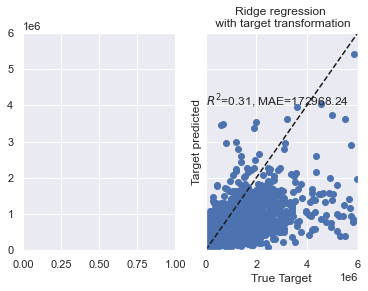

In [219]:
#sns.scatterplot(x= 'actual', y = 'calculated', data = predictions1)
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)
ax1.scatter(predictions1.actual, predictions1.calculated)
ax1.plot([0, 6000000], [0, 6000000], '--k')
ax1.set_ylabel('Target predicted')
ax1.set_xlabel('True Target')
ax1.set_title('Ridge regression \n with target transformation')
ax1.text(1, 4000000, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_score(predictions1.actual, predictions1.calculated), median_absolute_error(predictions1.actual, predictions1.calculated)))
ax1.set_xlim([0, 6000000])
ax1.set_ylim([0, 6000000])

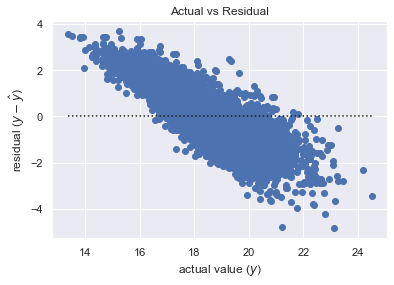

In [220]:
evaluate.plot_residuals(predictions1.log2value, predictions1.y_log_lm, predictions1)

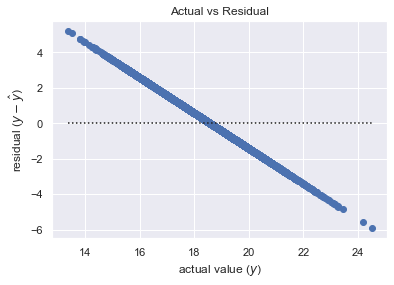

In [221]:
evaluate.plot_residuals(predictions1.log2value, predictions1.median_bl, predictions1)

In [169]:
from sklearn.metrics import median_absolute_error
predictions1.apply(lambda col: median_absolute_error(predictions1.log2value, col))

log2value    0.000000
y_log_lm     0.733594
median_bl    0.814753
dtype: float64

In [170]:
y_train3.log2value.median()

18.57167118154203

In [171]:
2**y_train3.log2value.median()

389610.0000000002

In [172]:
2**0.733594

1.6627761961563623

In [173]:
2**0.814753

1.7589969728468688

# lets transform y variable too

In [15]:
df.head(2)

,bathrooms,bedrooms,square_feet,fips,lot_size,pool,zip_code,year_built,latitude,longitude,assessed_value,tax_value,transaction_date,tax_rate,County,log2sf,log2lot_size,log2value,age
0,2.0,3.0,1458.0,6037,8284,1,97318,1970,34686163.0,-118113100.0,136104.0,2319.90,2017-06-23,0.017045,Los Angles,10.509775,13.016112,17.054350,30
1,1.0,2.0,1421.0,6037,6707,0,96018,1911,33999877.0,-118291863.0,35606.0,543.69,2017-06-30,0.015270,Los Angles,10.472691,12.711452,15.119833,89


Text(0.5, 0, 'assessed_value')

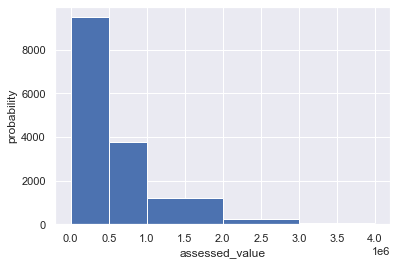

In [16]:
plt.hist(df.assessed_value, density=False, bins =[0, 500000, 1000000, 2000000, 3000000, 4000000])  # `density=False` would make counts
plt.ylabel('probability')
plt.xlabel('assessed_value')

In [21]:
y = df[['assessed_value']]
#y = np.exp((y + abs(y.min())) / 200)
#y_trans = np.log1p(y)

In [26]:
y_trans = quantile_transform(y,
                             n_quantiles=300,
                             output_distribution='normal',
                             copy=True).squeeze()

Text(0.5, 0, 'assessed_value')

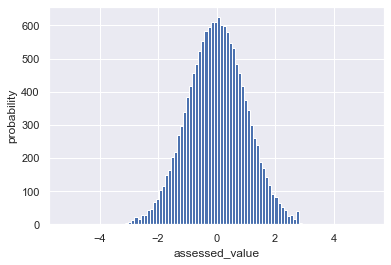

In [27]:
plt.hist(y_trans, density=False, bins =100)  # `density=False` would make counts
plt.ylabel('probability')
plt.xlabel('assessed_value')

In [29]:
train, test = train_test_split(df, train_size=.80, random_state=123)

In [47]:
X_train3 = train[['bedrooms', 'bathrooms', 'log2sf', 'log2lot_size', 'age']]
X_test3 = test[[ 'bedrooms','bathrooms', 'log2sf' , 'log2lot_size' ,'age']]
y_train3 = train[['assessed_value']]
y_test3 = test[['assessed_value']]

In [48]:
from sklearn.linear_model import RidgeCV
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import median_absolute_error, r2_score

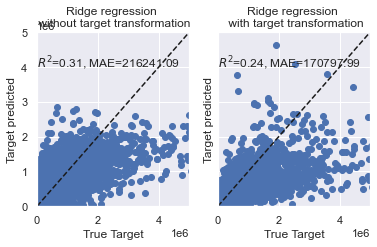

In [49]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

regr = RidgeCV()
regr.fit(X_train3, y_train3)
y_pred = regr.predict(X_train3)

ax0.scatter(y_train3, y_pred)
ax0.plot([0, 5000000], [0, 5000000], '--k')
ax0.set_ylabel('Target predicted')
ax0.set_xlabel('True Target')
ax0.set_title('Ridge regression \n without target transformation')
ax0.text(1, 4000000, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_score(y_train3, y_pred), median_absolute_error(y_train3, y_pred)))
ax0.set_xlim([0, 5000000])
ax0.set_ylim([0, 5000000])

regr_trans = TransformedTargetRegressor(
    regressor=RidgeCV(),
    transformer=QuantileTransformer(n_quantiles=300,
                                    output_distribution='normal'))
regr_trans.fit(X_train3, y_train3)
y_pred = regr_trans.predict(X_train3)

ax1.scatter(y_train3, y_pred)
ax1.plot([0, 5000000], [0, 5000000], '--k')
ax1.set_ylabel('Target predicted')
ax1.set_xlabel('True Target')
ax1.set_title('Ridge regression \n with target transformation')
ax1.text(1, 4000000, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_score(y_train3, y_pred), median_absolute_error(y_train3, y_pred)))
ax1.set_xlim([0, 5000000])
ax1.set_ylim([0, 5000000])

#f.suptitle("Boston housing data: distance to employment centers", y=0.035)
f.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

plt.show()

In [362]:
train, test = train_test_split(df, train_size=.80, random_state=123)

In [363]:
X_train4 = train[['bathrooms', 'log2sf']][train.assessed_value<500000]
y_train4 = train[['log2value']][train.assessed_value<500000]

In [364]:
#X_train4 = [train.assessed_value<1000000].train[['bedrooms', 'bathrooms', 'log2sf', 'log2lot_size', 'age']]
X_test4 = test[[ 'bathrooms', 'log2sf']]
#y_train4 = train[['assessed_value']]
y_test4 = test[['log2value']]

In [365]:
X_train4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7606 entries, 10631 to 11646
Data columns (total 2 columns):
bathrooms    7606 non-null float64
log2sf       7606 non-null float64
dtypes: float64(2)
memory usage: 178.3 KB


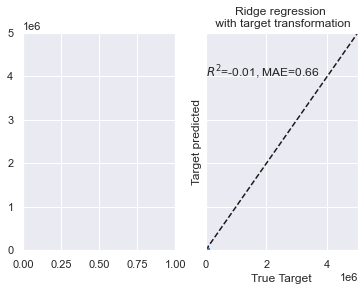

In [366]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

# regr = RidgeCV()
# regr.fit(X_train4, y_train4)
# y_pred = regr.predict(X_train4)

# ax0.scatter(y_train4, y_pred)
# ax0.plot([0, 5000000], [0, 5000000], '--k')
# ax0.set_ylabel('Target predicted')
# ax0.set_xlabel('True Target')
# ax0.set_title('Ridge regression \n without target transformation')
# ax0.text(1, 4000000, r'$R^2$=%.2f, MAE=%.2f' % (
#     r2_score(y_train4, y_pred), median_absolute_error(y_train4, y_pred)))
# ax0.set_xlim([0, 5000000])
# ax0.set_ylim([0, 5000000])

regr_trans = TransformedTargetRegressor(
    regressor=RidgeCV(),
    transformer=QuantileTransformer(n_quantiles=300,
                                    output_distribution='normal'))
regr_trans.fit(X_train4, y_train4)
y_pred = regr_trans.predict(X_train4)

ax1.scatter(y_train4, y_pred)
ax1.plot([0, 5000000], [0, 5000000], '--k')
ax1.set_ylabel('Target predicted')
ax1.set_xlabel('True Target')
ax1.set_title('Ridge regression \n with target transformation')
ax1.text(1, 4000000, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_score(y_train4, y_pred), median_absolute_error(y_train4, y_pred)))
ax1.set_xlim([0, 5000000])
ax1.set_ylim([0, 5000000])

#f.suptitle("Boston housing data: distance to employment centers", y=0.035)
#f.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

plt.show()

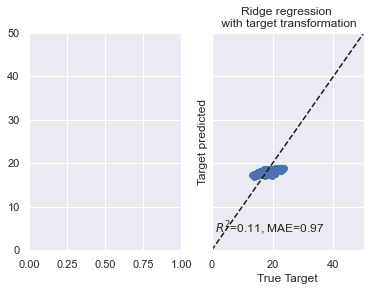

In [367]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

#regr_trans.fit(X_test4, y_test4)
y_pred = regr_trans.predict(X_test4)

ax1.scatter(y_test4, y_pred)
ax1.plot([0, 50], [0, 50], '--k')
ax1.set_ylabel('Target predicted')
ax1.set_xlabel('True Target')
ax1.set_title('Ridge regression \n with target transformation')
ax1.text(1, 4, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_score(y_test4, y_pred), median_absolute_error(y_test4, y_pred)))
ax1.set_xlim([0, 50])
ax1.set_ylim([0, 50])

#f.suptitle("Boston housing data: distance to employment centers", y=0.035)
#f.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

plt.show()

In [351]:
df.log2value.min()

13.358651200892886

In [352]:
df.log2value.max()

24.507992387794925

In [353]:
2**df.log2value.min()

10503.999999999996

In [354]:
2**df.log2value.max()

23858374.000000007

In [357]:
2**y_pred

array([[248665.91697328],
       [181092.87276872],
       [183494.57505023],
       ...,
       [243494.61171841],
       [259283.12921556],
       [306282.61218968]])

In [360]:
test.assessed_value

5884     127320.0
1583     576498.0
13532    161853.0
12732    357559.0
11248    355506.0
           ...   
2375     196992.0
4783      21902.0
5618      30399.0
10128    176699.0
3031     481004.0
Name: assessed_value, Length: 2975, dtype: float64

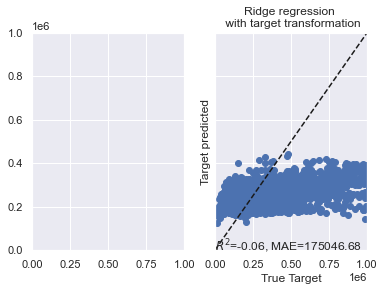

In [369]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)
#regr_trans.fit(X_test4, y_test4)
#y_pred = regr_trans.predict(X_test4)

ax1.scatter(test.assessed_value, 2**y_pred)
ax1.plot([0, 1000000], [0, 1000000], '--k')
ax1.set_ylabel('Target predicted')
ax1.set_xlabel('True Target')
ax1.set_title('Ridge regression \n with target transformation')
ax1.text(1, 4, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_score(test.assessed_value, 2**y_pred), median_absolute_error(test.assessed_value, 2**y_pred)))
ax1.set_xlim([0, 1000000])
ax1.set_ylim([0, 1000000])

#f.suptitle("Boston housing data: distance to employment centers", y=0.035)
#f.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

plt.show()

# Even with transforming target on log scale, there is no improvement in MAE